In [ ]:
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from tqdm.auto import tqdm

from src.configspace import (
    GPR_CONFIGSPACE,
    POLY_RIDGE_CONFIGSPACE,
    RANDOM_FOREST_CONFIGSPACE,
    RIDGE_CONFIGSPACE,
    SVR,
    SVR_CONFIGSPACE,
    XGB_CONFIGSPACE,
    GPRWithRBF,
    PolynomialRidge,
    RandomForestRegressor,
    Ridge,
    XGBRegressor,
)
from src.evaluation import evaluate_model_with_cross_validation
from src.hyperparameter_optimization import optimize_hyperparameters
from src.split import get_n_splits
from src.wrapper import ScikitLearnWrapper

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message=".*algorithm did not converge.*")

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.2
plt.rcParams["grid.color"] = "#cccccc"
plt.rcParams["axes.xmargin"] = 0

PHASE1_DIR = Path(".")
PROCESSED_DIR = PHASE1_DIR / "processed"

In [2]:
evaluations_df = pd.read_parquet(PROCESSED_DIR / "evaluations.parquet")
solvers_df = pd.read_parquet(PROCESSED_DIR / "solvers.parquet")
instances_df = pd.read_parquet(PROCESSED_DIR / "instances.parquet")

df = pd.merge(evaluations_df, solvers_df, left_on="solver_id", right_on="id").drop(columns=["id"])
df = pd.merge(df, instances_df, left_on="instance_id", right_on="id").drop(columns=["id"])
df

,solver_id,instance_id,generator,cost,ASCENT_CANDIDATES,BACKBONE_TRIALS,BACKTRACKING,CANDIDATE_SET_TYPE,EXTRA_CANDIDATES,EXTRA_CANDIDATE_SET_TYPE,...,mst_dists_span,mst_dists_coef_of_var,mst_dists_sum,nnds_min,nnds_median,nnds_mean,nnds_max,nnds_sd,nnds_span,nnds_coef_of_var
0,1251473931473582278,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,4.74,0.95,1.0,0.0,0.0,0.2,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
1,2289112522627003788,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,0.02,0.15,0.0,1.0,1.0,0.4,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
2,960932965817811220,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,3.72,0.20,0.0,1.0,2.0,0.9,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
3,39012066323493184,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,1.52,0.60,1.0,1.0,2.0,0.7,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
4,494182449327999052,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,84.44,0.90,1.0,1.0,3.0,0.3,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1286196444435323941,TSP/TRAIN/grid/019.tsp,grid,208.32,0.45,0.0,0.0,0.0,0.2,0.0,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201
99996,1435531534300921454,TSP/TRAIN/grid/019.tsp,grid,300.00,0.20,1.0,0.0,3.0,0.6,0.0,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201
99997,27607668447685341,TSP/TRAIN/grid/019.tsp,grid,3.21,0.95,1.0,1.0,3.0,0.9,0.0,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201
99998,2245205590089179674,TSP/TRAIN/grid/019.tsp,grid,17.23,0.65,0.0,0.0,1.0,0.5,0.0,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201


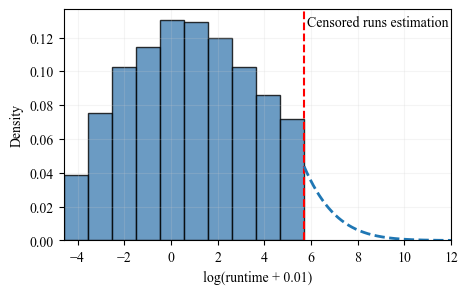

In [3]:
fig, ax = plt.subplots(figsize=(5, 3))

n, bins, patches = ax.hist(
    np.log(df.loc[df["cost"] < 300, "cost"] + 0.01),
    bins=10,
    color="steelblue",
    edgecolor="black",
    alpha=0.8,
    density=True,
)
ax.axvline(x=np.log(300 + 0.01), color="red", linestyle="--", label="300 seconds")

z = np.linspace(np.log(300 + 0.01), 12, 1000)
y = 1 - stats.norm.cdf(z, loc=0.75, scale=2.9)
ax.plot(z, y, ls='--', linewidth=2)

ax.set_xlabel('log(runtime + 0.01)')
ax.set_ylabel('Density')
ax.text(8.85, 0.129, "Censored runs estimation", va="center", ha="center")
# plt.savefig("log_runtime_distribution.pdf", bbox_inches="tight")
plt.show()

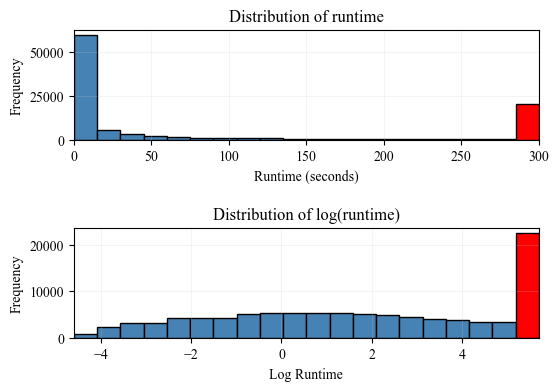

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 4))

n, bins_edges, patches = ax1.hist(
    df["cost"],
    bins=20,
    color="steelblue",
    edgecolor="black",
)

patches[-1].set_facecolor('red') 

ax1.set_title('Distribution of runtime')
ax1.set_xlabel('Runtime (seconds)')
ax1.set_ylabel('Frequency')

n2, bins_edges2, patches2 = ax2.hist(
    np.log(df["cost"] + 0.01),
    bins=20,
    color="steelblue",
    edgecolor="black",
)

patches2[-1].set_facecolor('red') 

ax2.set_title('Distribution of log(runtime)')
ax2.set_xlabel('Log Runtime')
ax2.set_ylabel('Frequency')

plt.subplots_adjust(hspace=0.8)
# plt.savefig("runtime_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

In [5]:
N_TRIALS = 500
N = 3
INSTANCE_NUMBER = 10
SOLVER_NUMBER = 90
RANDOM_STATE = 0

SPLITS = get_n_splits(
    df=df,
    n=N,
    instance_number=INSTANCE_NUMBER,
    solver_number=SOLVER_NUMBER,
    random_state=RANDOM_STATE,
)

### Ridge

In [ ]:
ridge_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=Ridge,
    wrapper_cls=ScikitLearnWrapper,
    configspace=RIDGE_CONFIGSPACE,
    splits=SPLITS,
    random_state=RANDOM_STATE,
    n_trials=N_TRIALS,
)

ridge_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=Ridge,
    wrapper_cls=ScikitLearnWrapper,
    configspace=RIDGE_CONFIGSPACE,
    splits=SPLITS,
    random_state=RANDOM_STATE,
    n_trials=N_TRIALS,
)

ridge_incumbent

[INFO][abstract_initial_design.py:147] Using 20 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:306] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:516] Added config 50e02f as new incumbent because there are no incumbents yet.
[INFO][abstract_intensifier.py:595] Added config ef53c2 and rejected config 50e02f as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config a6f641 and rejected config ef53c2 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config a1bf9d and rejected config a6f641 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config e6c848 and rejected config a1bf9d as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config 655962 and rejecte

{'alpha': 194.2588038884547,
 'random_state': 0,
 'model_cls': sklearn.linear_model._ridge.Ridge}

### PolynomialRidge

In [7]:
poly_ridge_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=PolynomialRidge,
    wrapper_cls=ScikitLearnWrapper,
    configspace=POLY_RIDGE_CONFIGSPACE,
    splits=SPLITS,
    random_state=RANDOM_STATE,
    n_trials=N_TRIALS,
)
poly_ridge_incumbent

[INFO][abstract_initial_design.py:147] Using 30 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:306] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:516] Added config 0f550a as new incumbent because there are no incumbents yet.
[INFO][abstract_intensifier.py:595] Added config a3d22f and rejected config 0f550a as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config ccf945 and rejected config a3d22f as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config 6db2ea and rejected config ccf945 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config a0f894 and rejected config 6db2ea as incumbent because it is not better than the incumbents on 1 instances:
[INFO][smbo.py:320] Finished 50 trials.
[INFO][abstract_intensifier

{'alpha': 999.9883799583358,
 'degree': 2,
 'interaction_only': False,
 'model_cls': src.configspace.PolynomialRidge}

### RandomForestRegressor

In [8]:
rf_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=RandomForestRegressor,
    wrapper_cls=ScikitLearnWrapper,
    configspace=RANDOM_FOREST_CONFIGSPACE,
    splits=SPLITS,
    random_state=RANDOM_STATE,
    n_trials=N_TRIALS,
)
rf_incumbent

[INFO][abstract_initial_design.py:147] Using 60 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:306] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:516] Added config f59857 as new incumbent because there are no incumbents yet.
[INFO][smbo.py:320] Finished 50 trials.
[INFO][abstract_intensifier.py:595] Added config aeca41 and rejected config f59857 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config e9fa3a and rejected config aeca41 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config b77547 and rejected config e9fa3a as incumbent because it is not better than the incumbents on 1 instances:
[INFO][smbo.py:320] Finished 100 trials.
[INFO][smbo.py:320] Finished 150 trials.
[INFO][smbo.py:320] Finished 200 trials.
[INFO][smbo.py:320] Finished 250 trials.
[INFO][smbo.py:320] 

{'max_depth': 12,
 'max_features': 0.6005196924356,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_jobs': -1,
 'random_state': 0,
 'model_cls': sklearn.ensemble._forest.RandomForestRegressor}

### XGBRegressor

In [9]:
xgb_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=XGBRegressor,
    wrapper_cls=ScikitLearnWrapper,
    configspace=XGB_CONFIGSPACE,
    splits=SPLITS,
    random_state=RANDOM_STATE,
    n_trials=N_TRIALS,
)
xgb_incumbent

[INFO][abstract_initial_design.py:147] Using 100 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:306] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:516] Added config 0610fc as new incumbent because there are no incumbents yet.
[INFO][smbo.py:320] Finished 50 trials.
[INFO][smbo.py:320] Finished 100 trials.
[INFO][smbo.py:320] Finished 150 trials.
[INFO][smbo.py:320] Finished 200 trials.
[INFO][smbo.py:320] Finished 250 trials.
[INFO][smbo.py:320] Finished 300 trials.
[INFO][smbo.py:320] Finished 350 trials.
[INFO][smbo.py:320] Finished 400 trials.
[INFO][smbo.py:320] Finished 450 trials.
[INFO][smbo.py:320] Finished 500 trials.
[INFO][smbo.py:328] Configuration budget is exhausted:
[INFO][smbo.py:329] --- Remaining wallclock time: inf
[INFO][smbo.py:330] --- Remaining cpu time: inf
[INFO][smbo.py:331] --- Remaining trials: 0


{'colsample_bytree': 0.6334392605349,
 'gamma': 3.1028234772384,
 'learning_rate': 0.001846333114,
 'max_depth': 5,
 'min_child_weight': 9,
 'n_estimators': 501,
 'reg_alpha': 6.9167496732409,
 'reg_lambda': 9.7078357604554,
 'seed': 0,
 'subsample': 0.8860676749609,
 'model_cls': xgboost.sklearn.XGBRegressor}

### SVR

In [10]:
svr_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=SVR,
    wrapper_cls=ScikitLearnWrapper,
    configspace=SVR_CONFIGSPACE,
    splits=SPLITS,
    random_state=RANDOM_STATE,
    n_trials=N_TRIALS,
)
svr_incumbent

[INFO][abstract_initial_design.py:147] Using 60 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:306] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:516] Added config 383a37 as new incumbent because there are no incumbents yet.
[INFO][abstract_intensifier.py:595] Added config d88a62 and rejected config 383a37 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config 0b608a and rejected config d88a62 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config c6d22c and rejected config 0b608a as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config 47c9d8 and rejected config c6d22c as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config 8c7d40 and rejecte

{'C': 3.4469281701267,
 'kernel': 'rbf',
 'max_iter': 100000,
 'tol': 0.0091222119776,
 'gamma': 'scale',
 'model_cls': sklearn.svm._classes.SVR}

### GPRWithRBF

In [11]:
gpr_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=GPRWithRBF,
    wrapper_cls=ScikitLearnWrapper,
    configspace=GPR_CONFIGSPACE,
    splits=SPLITS,
    random_state=RANDOM_STATE,
    n_trials=N_TRIALS,
)
gpr_incumbent

[INFO][abstract_initial_design.py:147] Using 30 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:306] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:516] Added config 0b9b43 as new incumbent because there are no incumbents yet.
[INFO][abstract_intensifier.py:595] Added config 3442b9 and rejected config 0b9b43 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config ec05c2 and rejected config 3442b9 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config d1bedb and rejected config ec05c2 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config 1456e2 and rejected config d1bedb as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config 9e7ffc and rejecte

{'alpha': 0.0999951083289,
 'length_scale': 4.8230992873845,
 'length_scale_bounds': 'fixed',
 'model_cls': src.configspace.GPRWithRBF}

## Comparison

In [ ]:
model_info_list = [
    {
        "wrapper": ScikitLearnWrapper(**ridge_incumbent),
        "name": "Ridge Regression"
    },
    {
        "wrapper": ScikitLearnWrapper(**poly_ridge_incumbent),
        "name": "Polynomial Regression"
    },
    {
        "wrapper": ScikitLearnWrapper(**svr_incumbent),
        "name": "Support Vector Regression"
    },
    {
        "wrapper": ScikitLearnWrapper(**gpr_incumbent),
        "name": "Gaussian Process Regression"
    },
    {
        "wrapper": ScikitLearnWrapper(**rf_incumbent),
        "name": "Random Forest"
    },
    {
        "wrapper": ScikitLearnWrapper(**xgb_incumbent),
        "name": "XGBoost"
    }
]
 
random_state_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
solver_number_list = [5, 10, 15, 20, 30, 50, 70, 100, 150, 200, 300, 500]
total_iterations = len(random_state_list) * len(solver_number_list) * len(model_info_list)
pbar = tqdm(total=total_iterations, desc="Evaluating models")

records = []

for random_state in random_state_list:
    for solver_number in solver_number_list:
        pbar.set_description(f"RS={random_state}, Solvers={solver_number}")
        splits = get_n_splits(
            df,
            n=5,
            instance_number=10,
            solver_number=solver_number,
            random_state=random_state,
        )
        for model_info in model_info_list:
            pbar.set_postfix(model=model_info["name"])

            result = evaluate_model_with_cross_validation(
                df,
                wrapper=model_info["wrapper"],
                splits=splits,
                random_state=random_state,
            )
            result["random_state"] = random_state
            result["solver_number"] = solver_number
            result["name"] = model_info["name"]
            records.append(result)
            pbar.update(1)

pbar.close()
result_df = pd.DataFrame(records)

Evaluating models:   0%|          | 0/1440 [00:00<?, ?it/s]

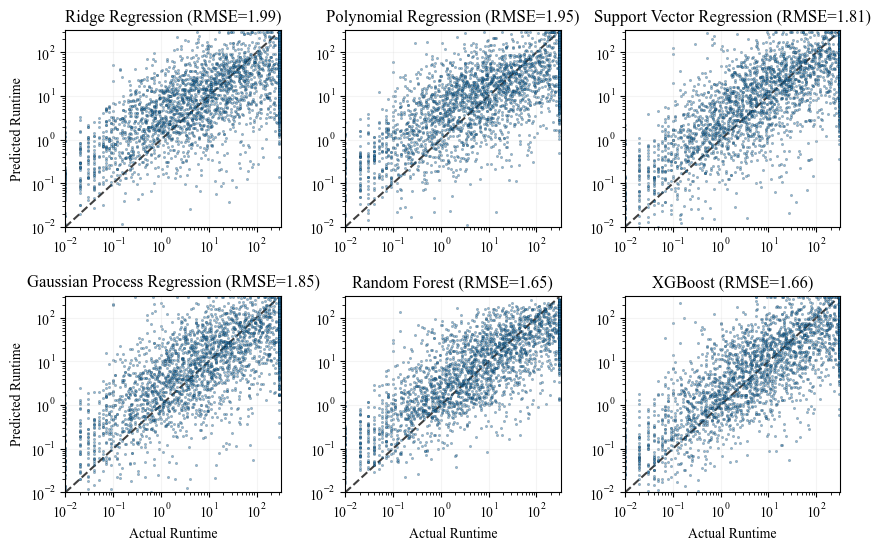

In [19]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))
axs = axs.flatten()

plot_df = result_df.loc[(result_df["random_state"] == 4) & (result_df["solver_number"] == 300)].reset_index(drop=True)

for i, result in plot_df.iterrows():
    ax = axs[i]

    sc = ax.scatter(
        result["y_test_not_censored"],
        result["y_pred"],
        alpha=0.5,
        edgecolors="k",
        lw=0.2,
        s=3,
    )
    ax.set_xscale("log")
    ax.set_yscale("log")

    ax.set_xlim(0.01, 320)
    ax.set_ylim(0.01, 320)
    ax.plot([0.01, 300], [0.01, 300], "k--", alpha=0.75, zorder=0)
    ax.set_title(f'{result["name"]} (RMSE={result["rmse"]:.2f})')

axs[0].set_ylabel("Predicted Runtime")
axs[3].set_ylabel("Predicted Runtime")
axs[3].set_xlabel("Actual Runtime")
axs[4].set_xlabel("Actual Runtime")
axs[5].set_xlabel("Actual Runtime")
plt.subplots_adjust(wspace=0.3, hspace=0.35)
# plt.savefig("runtime_predictions.png", dpi=300, bbox_inches="tight")
plt.show()

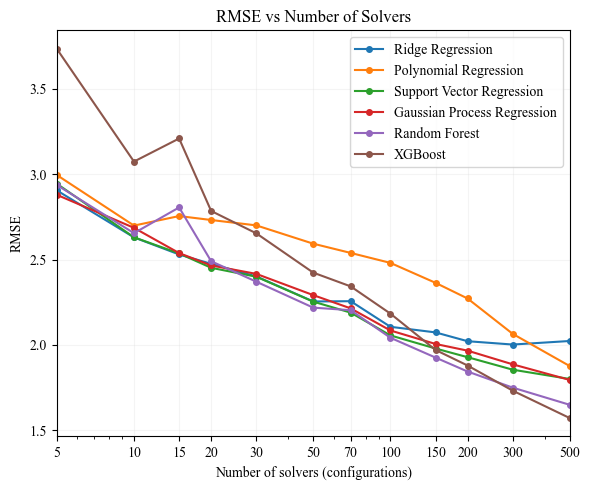

In [23]:
fig, ax = plt.subplots(figsize=(6, 5))

plot_df = result_df.groupby(["name", "solver_number"], sort=False)["rmse"].mean().reset_index()

for name, group in plot_df.groupby("name", sort=False):
    plt.plot(
        group['solver_number'], 
        group['rmse'], 
        'o-', 
        label=name,
        linewidth=1.5,
         markersize=4
    )

plt.xscale('log')
plt.xlabel('Number of solvers (configurations)')
plt.ylabel('RMSE')
plt.legend(loc='best', frameon=True)
plt.xticks(plot_df['solver_number'].unique(), plot_df['solver_number'].unique())
plt.title('RMSE vs Number of Solvers')
plt.tight_layout()
# plt.savefig("rmse_vs_solver_number.png", dpi=300, bbox_inches="tight")
plt.show()

In [21]:
result_df.pivot_table(
    columns="name",
    index="solver_number",
    values="rmse",
)

name,Gaussian Process Regression,Polynomial Regression,Random Forest,Ridge Regression,Support Vector Regression,XGBoost
solver_number,,,,,,
5,2.878971,2.994928,2.936589,2.904777,2.944036,3.733762
10,2.685409,2.698597,2.654227,2.629596,2.630031,3.073404
15,2.537695,2.754365,2.804879,2.529580,2.535485,3.208540
20,2.465197,2.731336,2.489814,2.474561,2.451465,2.784173
30,2.415825,2.699763,2.370149,2.400912,2.399157,2.653172
50,2.291594,2.592690,2.218190,2.254307,2.253441,2.423245
70,2.213801,2.538519,2.203222,2.255863,2.188949,2.342612
100,2.084412,2.480182,2.041907,2.106036,2.055685,2.183194
150,2.005486,2.363414,1.925751,2.073139,1.978908,1.970354
